In [1]:
from typing import Callable

import h5py
import matplotlib.pyplot as plt
import pandas as pd
import modred as mr
import numpy as np
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from pathlib import Path

from src.models import MLP
from src.solvers.fem import Poisson1D, HelmholtzImpedance1D, ParameterizedSolver, plot_bases
from src.utils.helpers import PairDataset, MSE, RelMSE

In [2]:
sns.set_theme(style='whitegrid', palette='deep')

# Rectify the data

In [ ]:
path = Path('data/230517/base')

In [63]:
Y_trn = h5py.File((path / 'hfparams.h5'), 'r')['Parameters'][:].T
Y_val = h5py.File((path / 'hfparamsTest.h5'), 'r')['ParametersTest'][:].T
S_trn = h5py.File((path / 'hfsolutions.h5'), 'r')['HfSolutions'][:].T
S_val = h5py.File((path / 'hfsolutionsTest.h5'), 'r')['HfSolutionsTest'][:].T

# Visualize the data

In [16]:
path = Path('data/230517/base')
n_trn = 512
n_val = 128

Y_trn = np.load(path / 'Y_trn.npy')[:, :n_trn]
Y_val = np.load(path / 'Y_val.npy')[:, :n_val]
S_trn = np.load(path / 'S_trn.npy')[:, :n_trn]
S_val = np.load(path / 'S_val.npy')[:, :n_val]

print(f'Sizes: {S_trn.shape[1]}, {S_val.shape[1]}')
print(f'Ranks: {np.linalg.matrix_rank(S_trn)}, {np.linalg.matrix_rank(S_val)}')

Sizes: 512, 128
Ranks: 77, 74


[Text(0.5, 0, '$i$'), Text(0, 0.5, '$s_i$'), None]

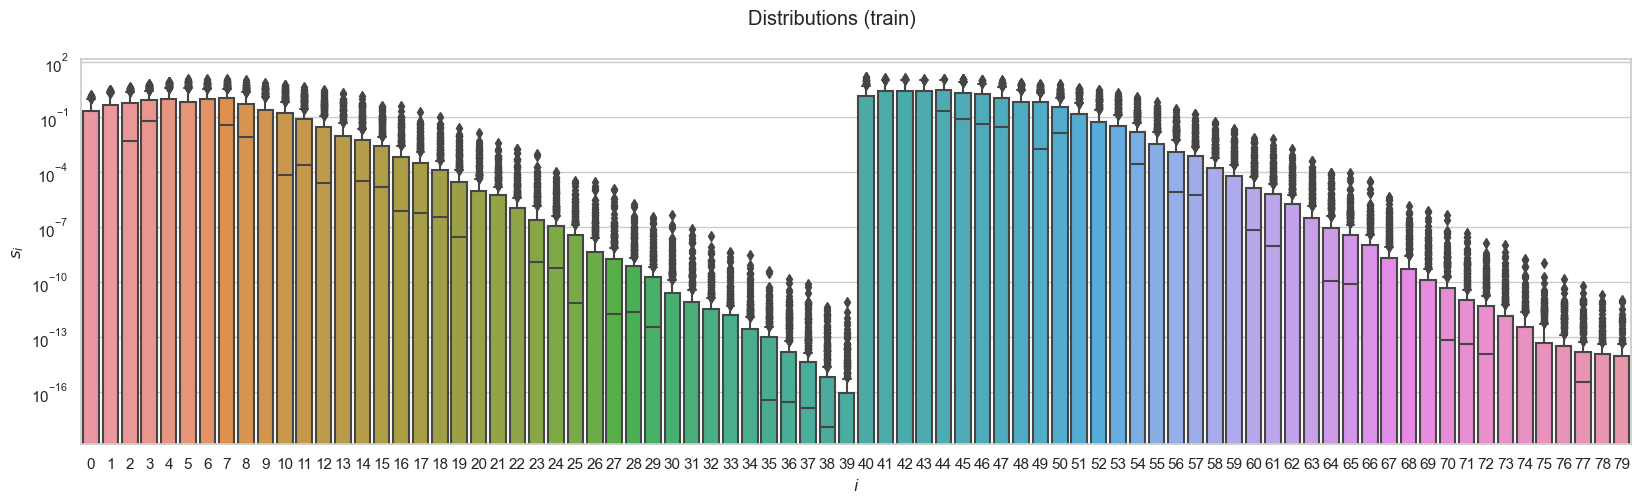

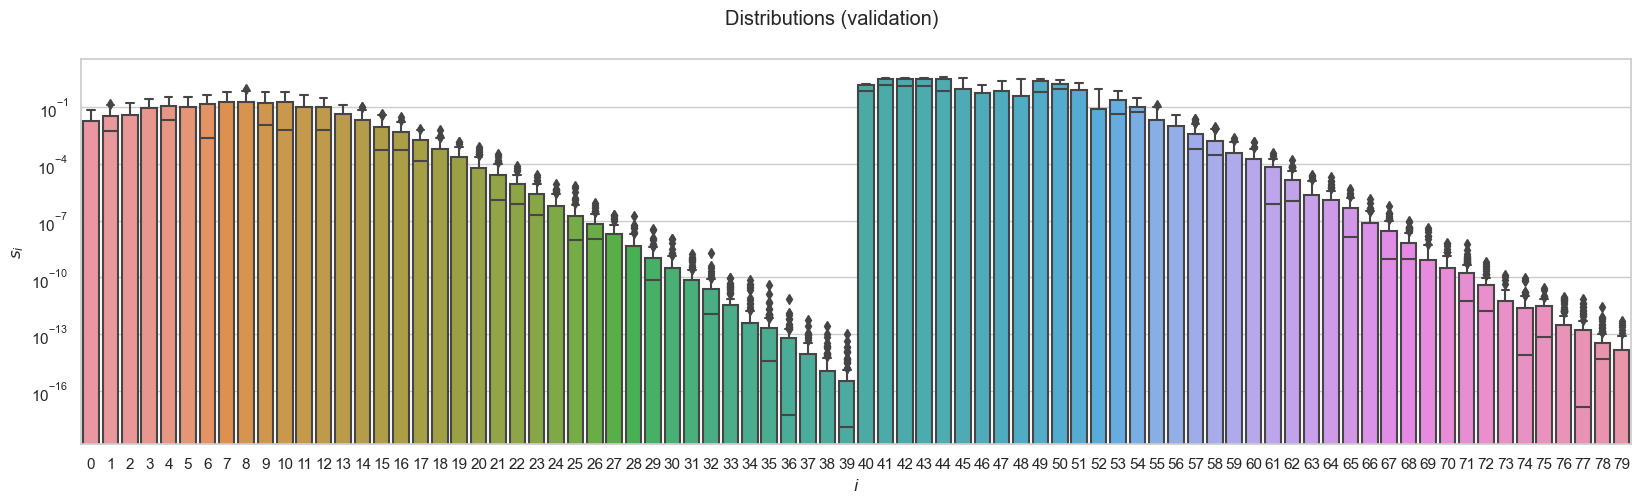

In [5]:
# Plot the distributions of the solution matrix (train)
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(20, 5))
fig.suptitle('Distributions (train)')
if np.iscomplexobj(S_trn):
    sns.boxplot(pd.DataFrame(np.concatenate([S_trn.real, S_trn.imag]).T), ax=ax)
else:
    sns.boxplot(pd.DataFrame(S_trn.T), ax=ax)
ax.set(xlabel='$i$', ylabel='$s_i$', yscale='log')

# Plot the distributions of the solution matrix (validation)
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(20, 5))
fig.suptitle('Distributions (validation)')
if np.iscomplexobj(S_val):
    sns.boxplot(pd.DataFrame(np.concatenate([S_val.real, S_val.imag]).T), ax=ax)
else:
    sns.boxplot(pd.DataFrame(S_val.T), ax=ax)
ax.set(xlabel='$i$', ylabel='$s_i$', yscale='log')

In [6]:
mean_S_trn, std_S_trn = S_trn.mean(axis=1), S_trn.std(axis=1)
mean_S_val, std_S_val = S_val.mean(axis=1), S_val.std(axis=1)
mean_Y_trn, std_Y_trn = Y_trn.mean(axis=1), Y_trn.std(axis=1)
mean_Y_val, std_Y_val = Y_val.mean(axis=1), Y_val.std(axis=1)

[Text(0.5, 0, '$i$'), Text(0, 0.5, '$s_i$'), None]

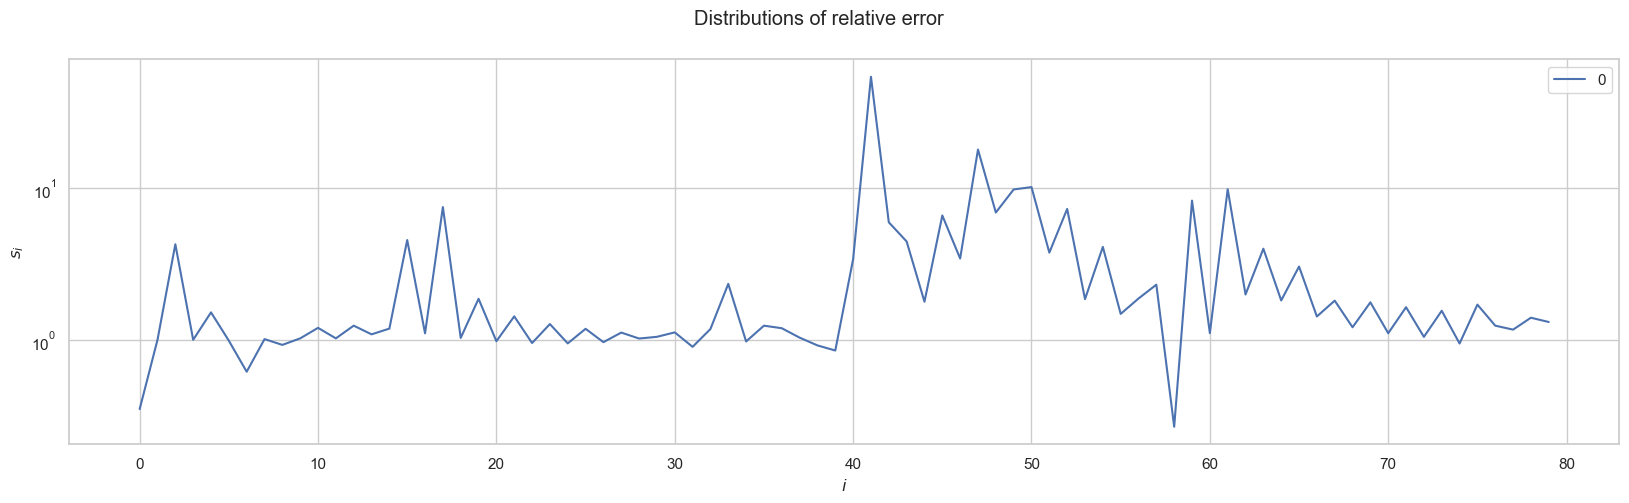

In [7]:
err = np.abs((mean_S_trn - mean_S_val) / mean_S_trn)

# Plot the distributions of the relative error in mean or std
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(20, 5))
fig.suptitle('Distributions of relative error')
sns.lineplot(err, ax=ax)
ax.set(xlabel='$i$', ylabel='$s_i$', yscale='log')


# Check dimension of the reduced basis

[None, Text(0.5, 0, 'k'), Text(0, 0.5, '$\\lambda_k$')]

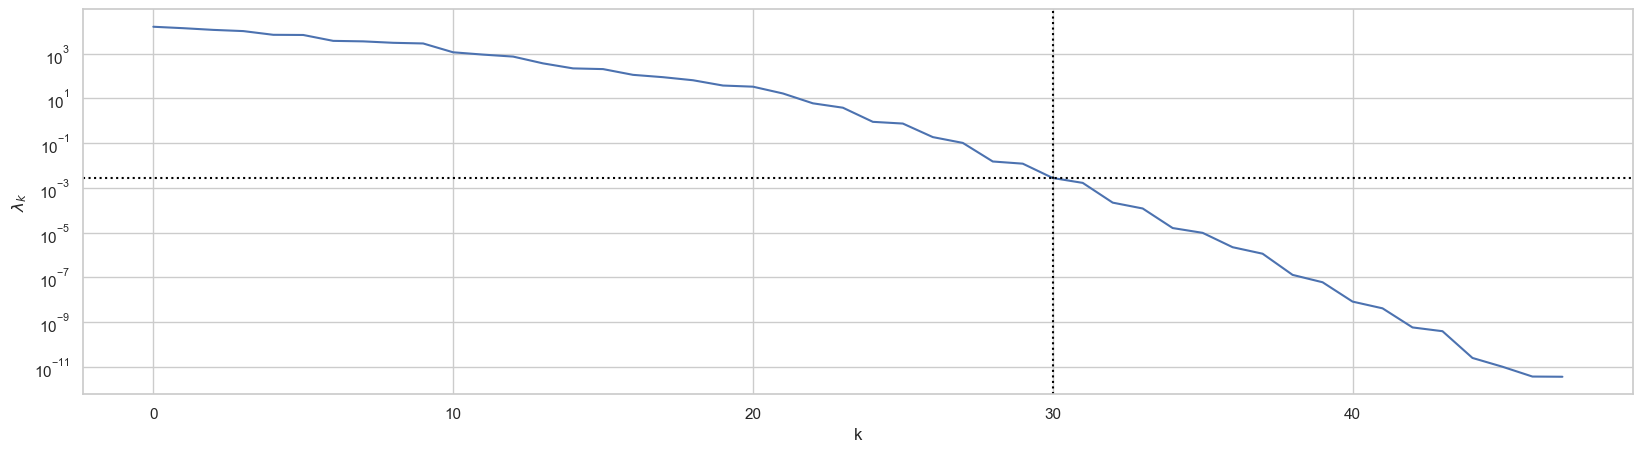

In [17]:
L = 30

# Check the dimension of the reduced basis
assert L <= np.linalg.matrix_rank(S_trn)

# Get the reduced basis and the coefficients
pod = mr.compute_POD_arrays_snaps_method(
    S_trn,
    list(mr.range(L))
)
V = pod.modes

# Plot the eigenvalues
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
sns.lineplot(x=range(len(pod.eigvals)), y=pod.eigvals, ax=ax)
ax.axvline(x=L, color='black', linestyle=':')
ax.axhline(y=pod.eigvals[L], color='black', linestyle=':')
ax.set(yscale='log', xlabel='k', ylabel='$\\lambda_k$')

# Get projection errors

In [32]:
# TODO: Move to a script
Ls = range(1, 31)

losses = {'train': [None] * len(Ls), 'validation': [None] * len(Ls)}
errors = {'train': [None] * len(Ls), 'validation': [None] * len(Ls)}
for idx, L in enumerate(Ls):
    pod = mr.compute_POD_arrays_snaps_method(S_trn, list(mr.range(L)))
    V = pod.modes

    S_trn_ = V @ V.conj().T @ S_trn
    S_val_ = V @ V.conj().T @ S_val
    loss_trn = MSE(torch.tensor(S_trn_).T, torch.tensor(S_trn).T).item()
    loss_val = MSE(torch.tensor(S_val_).T, torch.tensor(S_val).T).item()
    err_trn = RelMSE(torch.tensor(S_trn_).T, torch.tensor(S_trn).T).item()
    err_val = RelMSE(torch.tensor(S_val_).T, torch.tensor(S_val).T).item()

    # Store the losses
    losses['train'][idx] = loss_trn
    losses['validation'][idx] = loss_val
    # Store the errors
    errors['train'][idx] = err_trn
    errors['validation'][idx] = err_val

df = pd.DataFrame({
    'L': Ls,
    'D': None,
    'W': None,
    'train error': errors['train'],
    'validation error': errors['validation'],
    'train loss': losses['train'],
    'validation loss': losses['validation'],
})
df.to_csv('results/OneArc/cng_V.csv')

# Plot convergence

[Text(0, 0.5, '$\\lambda_L$'), None]

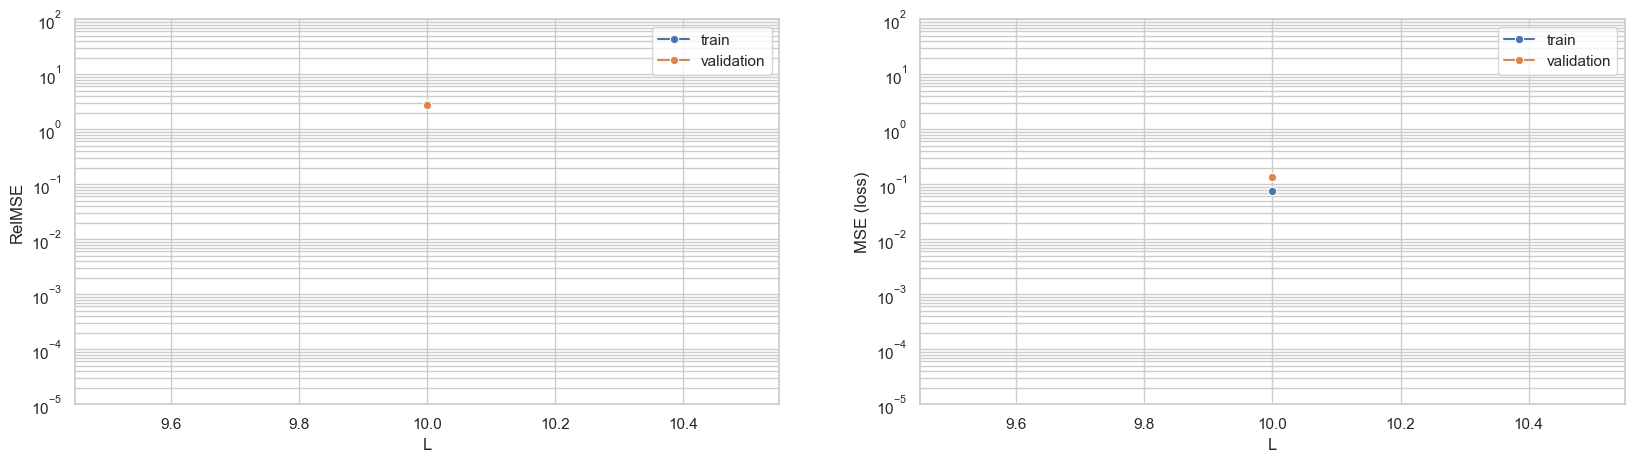

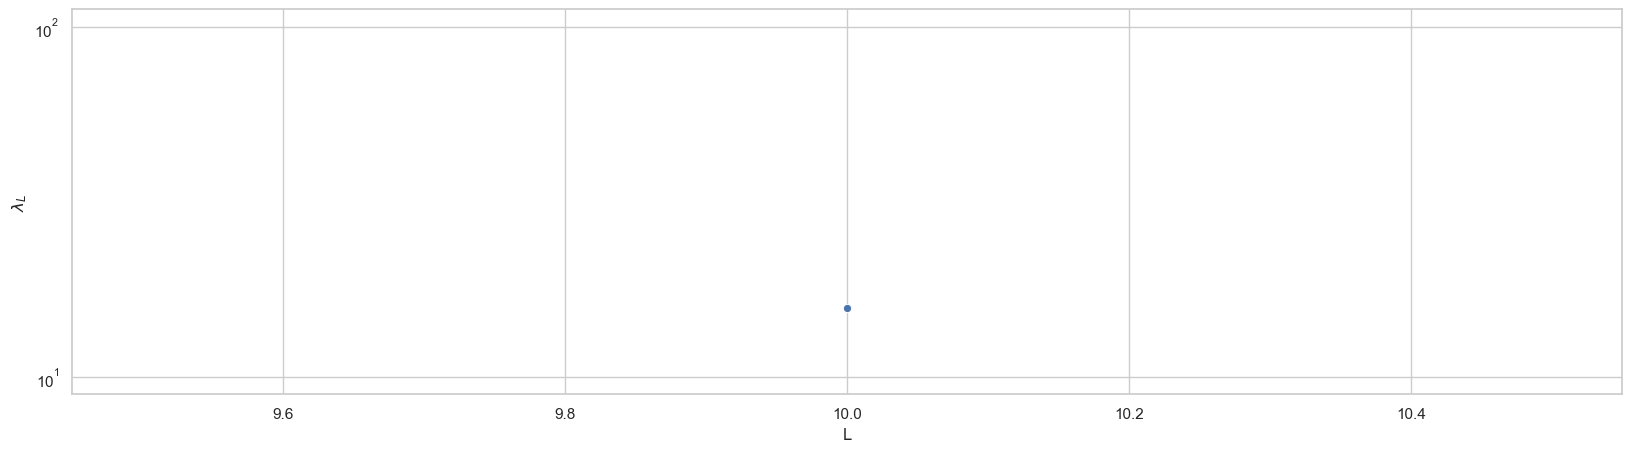

In [9]:
# df = pd.DataFrame({
#     'L': Ls,
#     'D': D,
#     'W': W,
#     'eigval': eigvals,
#     'train error': errors['train'],
#     'validation error': errors['validation'],
#     'train loss': losses['train'],
#     'validation loss': losses['validation'],
# })

# # Plot the errors
# fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(20, 5))
# sns.lineplot(df, x='L', y='train error', marker='o', label='train', ax=axs[0])
# sns.lineplot(df, x='L', y='validation error', marker='o', label='validation', ax=axs[0])
# sns.lineplot(df, x='L', y='train loss', marker='o', label='train', ax=axs[1])
# sns.lineplot(df, x='L', y='validation loss', marker='o', label='validation', ax=axs[1])
# axs[0].set(ylabel='RelMSE', ylim=[1e-05, 1e+02])
# axs[1].set(ylabel='MSE (loss)', ylim=[1e-05, 1e+02])
# for ax in axs:
#     ax.grid(True, which='minor')
#     ax.set(yscale='log')
#     ax.legend()

# # Plot the singular values
# fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(20, 5))
# sns.lineplot(df, x='L', y='eigval', marker='o', ax=ax)
# ax.set(ylabel='$\\lambda_L$', yscale='log')

In [24]:
# df.to_csv(f'results/OneArc/D{D}W{W}_convg.csv')

## Plot multiple convergences

In [ ]:
dfs = []
for W in [10, 20, 30, 40]:
    df = pd.read_csv(f'results/OneArc/D2W{W}_convg.csv')
    df['D'] = 2
    df['W'] = W
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

fg, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey=True)
Y = 'validation error'
sns.lineplot(
    data=df,
    x='L',
    y=Y,
    hue='W',
    palette='deep',
    marker='o',
    ax=axs[0],
)
sns.lineplot(
    data=df.groupby(['D', 'W']).aggregate(np.min),
    x='W',
    y=Y,
    # hue='W',
    marker='o',
    ax=axs[1],
)

sns.lineplot(
    data=pd.read_csv(f'results/OneArc/V_convg.csv'),
    x='L',
    y=Y,
    color='black',
    marker='*',
    ax=axs[0],
)
# axs[1].axhline(y=1e-08, linestyle=':', color='black')

axs[0].set(yscale='log', ylabel='$\\tilde{\\varepsilon}_{val}$')
for ax in axs:
    ax.grid(True, which='minor')